## Splink deduplication demo 

In this demo we link and simultaneously two datasets which themselves contain duplicates.

The purpose is to provide an end-to-end example of how to use the package

I print the output at each stage using `spark_dataframe.show()`.  This is for instructional purposes only - it degrades performance and shouldn't be used in a production setting.

## Step 1:  Imports and setup

The following is just boilerplate code that sets up the Spark session and sets some other non-essential configuration options

In [1]:
import pandas as pd 
pd.options.display.max_columns = 500
pd.options.display.max_rows = 100

In [2]:
import logging 
logging.basicConfig()  # Means logs will print in Jupyter Lab

# Set to DEBUG if you want splink to log the SQL statements it's executing under the hood
logging.getLogger("splink").setLevel(logging.INFO)

In [3]:
from pyspark.context import SparkContext, SparkConf
from pyspark.sql import SparkSession, Window
from pyspark.sql.types import StructType
import pyspark.sql.functions as f

conf=SparkConf()

# Load in a jar that provides extended string comparison functions such as Jaro Winkler.
# Splink 
conf.set('spark.driver.extraClassPath', 'jars/scala-udf-similarity-0.0.6.jar')
conf.set('spark.jars', 'jars/scala-udf-similarity-0.0.6.jar')   


# WARNING:
# These config options are appropriate only if you're running Spark locally!!!
conf.set('spark.driver.memory', '4g')
conf.set("spark.sql.shuffle.partitions", "8") 

sc = SparkContext.getOrCreate(conf=conf)

spark = SparkSession(sc)

 # Register UDFs
from pyspark.sql import types
spark.udf.registerJavaFunction('jaro_winkler_sim', 'uk.gov.moj.dash.linkage.JaroWinklerSimilarity', types.DoubleType())
spark.udf.registerJavaFunction('Dmetaphone', 'uk.gov.moj.dash.linkage.DoubleMetaphone', types.StringType())

## Step 2:  Read in data

The `l` and `r` stand for 'left' and 'right.  It doesn't matter which of the two datasets you choose as the left, performance and results will be the same.


⚠️ Note that `splink` makes the following assumptions about your data:

-  There is a field containing a unique record identifier in each dataset
-  The two datasets being linked have common column names - e.g. date of birth is represented in both datasets in a field of the same name.   In many cases, this means that the user needs to rename columns prior to using `splink`


In [4]:
df_l = spark.read.parquet("data/fake_df_l_link_dedupe_test.parquet")
df_r = spark.read.parquet("data/fake_df_r_link_dedupe_test.parquet")
df_l.show(5)
df_r.show(5)

+---------+----------+-------+----------+------------+--------------------+-----+
|unique_id|first_name|surname|       dob|        city|               email|group|
+---------+----------+-------+----------+------------+--------------------+-----+
|        0|    Julia |   null|2015-10-29|      London| hannah88@powers.com|    0|
|        1|    Julia | Taylor|2015-07-31|      London| hannah88@powers.com|    0|
|        2|      oNah| Watson|2008-03-23|      Bolton|matthew78@ballard...|    1|
|        3|     Noah | Watson|2008-03-23|      Bolton|matthew78@ballard...|    1|
|        4|    Molly |   Bell|2002-01-05|Peterborough|                null|    2|
+---------+----------+-------+----------+------------+--------------------+-----+
only showing top 5 rows

+---------+----------+-------+----------+------+--------------------+-----+
|unique_id|first_name|surname|       dob|  city|               email|group|
+---------+----------+-------+----------+------+--------------------+-----+
|        

## Step 3:  Configure splink using the `settings` object

Most of `splink` configuration options are stored in a settings dictionary.  This dictionary allows significant customisation, and can therefore get quite complex.  

💥 We provide an tool for helping to author valid settings dictionaries, which includes tooltips and autocomplete, which you can find [here](https://robinlinacre.com/simple_sparklink_settings_editor/).

Customisation overrides default values built into splink.  For the purposes of this demo, we will specify a simple settings dictionary, which means we will be relying on these sensible defaults.

To help with authoring and validation of the settings dictionary, we have written a [json schema](https://json-schema.org/), which can be found [here](https://github.com/moj-analytical-services/splink/blob/dev/splink/files/settings_jsonschema.json).  




In [5]:
settings = {
    "link_type": "link_and_dedupe",
    "blocking_rules": [
        "l.first_name = r.first_name",
        "l.surname = r.surname",
        "l.dob = r.dob"
    ],
    "comparison_columns": [
        {
            "col_name": "first_name",
            "num_levels": 3,
            "term_frequency_adjustments": True
        },
        {
            "col_name": "surname",
            "num_levels": 3,
            "term_frequency_adjustments": True
        },
        {
            "col_name": "dob"
        },
        {
            "col_name": "city"
        },
        {
            "col_name": "email"
        }
    ],
    "additional_columns_to_retain": ["group"]
}

In words, this setting dictionary says:
- We are performing a link and deduplication task (the other options are `link_only`, or `dedupe_only`)
- We are going generate comparisons subject to the blocking rules contained in the specified array
- When comparing records, we will use information from the `first_name`, `surname`, `dob`, `city` and `email` columns to compute a match score.
- For `first_name` and `surname`, string comparisons will have three levels:
    - Level 2: Strings are (almost) exactly the same
    - Level 1: Strings are similar 
    - Level 0: No match
- We will make adjustments for term frequencies on the `first_name` and `surname` columns
- We will retain the `group` column in the results even though this is not used as part of comparisons.  This is a labelled dataset and `group` contains the true match - i.e. where group matches, the records pertain to the same person

## Step 4:  Estimate match scores using the Expectation Maximisation algorithm
Columns are assumed to be strings by default.  See the 'comparison vector settings' notebook for details of configuration options.

In [6]:
from splink import Splink

linker = Splink(settings, spark, df_l=df_l, df_r=df_r)
df_e = linker.get_scored_comparisons()
df_e.persist()  # Later, we will make term frequency adjustments.  Persist caches these results in memory, preventing them having to be recomputed when we make these adjustments.

INFO:splink.iterate:Iteration 0 complete
INFO:splink.iterate:Iteration 1 complete
INFO:splink.iterate:Iteration 2 complete
INFO:splink.iterate:Iteration 3 complete
INFO:splink.iterate:Iteration 4 complete
INFO:splink.iterate:Iteration 5 complete
INFO:splink.iterate:Iteration 6 complete
INFO:splink.iterate:Iteration 7 complete
INFO:splink.iterate:Iteration 8 complete
INFO:splink.iterate:Iteration 9 complete


DataFrame[match_probability: double, unique_id_l: bigint, unique_id_r: bigint, first_name_l: string, first_name_r: string, gamma_first_name: int, prob_gamma_first_name_non_match: double, prob_gamma_first_name_match: double, surname_l: string, surname_r: string, gamma_surname: int, prob_gamma_surname_non_match: double, prob_gamma_surname_match: double, dob_l: string, dob_r: string, gamma_dob: int, prob_gamma_dob_non_match: double, prob_gamma_dob_match: double, city_l: string, city_r: string, gamma_city: int, prob_gamma_city_non_match: double, prob_gamma_city_match: double, email_l: string, email_r: string, gamma_email: int, prob_gamma_email_non_match: double, prob_gamma_email_match: double, _source_table_l: string, _source_table_r: string, group_l: bigint, group_r: bigint]

## Step 5: Inspect results 

Each row in the results table represents a comparison of two input records.

Note that since this is a link and dedupe task, there will be record comparisons of three types:
-  Comparison between two records both originating from `df_l`.  
-  Comparison between two records both originating from `df_r`.  
-  Comparison between one record from `df_l` and one record from `df_r`

Information about the source table is included in the `_source_table_l` and `_source_table_r` fields.

In [7]:
# Inspect main dataframe that contains the match scores
cols_to_inspect = ["match_probability","unique_id_l", "_source_table_l","unique_id_r","_source_table_r","group_l", "group_r", "first_name_l","first_name_r","surname_l","surname_r","dob_l","dob_r","city_l","city_r","email_l","email_r"]

df_e.toPandas()[cols_to_inspect].sort_values(["unique_id_l", "unique_id_r"]).head(10)

,match_probability,unique_id_l,_source_table_l,unique_id_r,_source_table_r,group_l,group_r,first_name_l,first_name_r,surname_l,surname_r,dob_l,dob_r,city_l,city_r,email_l,email_r
1,0.997613,0,left,0,right,0,0,Julia,Julia,None,Taylor,2015-10-29,2016-01-27,London,London,hannah88@powers.com,hannah88@powers.com
0,0.999962,0,left,1,right,0,0,Julia,Julia,None,Taylor,2015-10-29,2015-10-29,London,None,hannah88@powers.com,hannah88opowersc@m
2,0.997613,0,left,1,left,0,0,Julia,Julia,None,Taylor,2015-10-29,2015-07-31,London,London,hannah88@powers.com,hannah88@powers.com
1213,0.984606,0,right,1,right,0,0,Julia,Julia,Taylor,Taylor,2016-01-27,2015-10-29,London,None,hannah88@powers.com,hannah88opowersc@m
3585,0.036772,0,right,97,right,0,26,Julia,Harry,Taylor,Taylor,2016-01-27,2017-09-01,London,London,hannah88@powers.com,coltonray@lee.com
3584,0.036772,0,right,245,right,0,62,Julia,Nancy,Taylor,Taylor,2016-01-27,1989-07-25,London,London,hannah88@powers.com,wagnershane@landry.com
3583,0.036772,0,right,246,right,0,62,Julia,Nancy,Taylor,Taylor,2016-01-27,1989-08-19,London,London,hannah88@powers.com,wagnershane@landry.com
3582,0.036772,0,right,248,right,0,62,Julia,Nacy,Taylor,Taylor,2016-01-27,1989-07-25,London,London,hannah88@powers.com,wagnershane@landry.com
3581,0.001874,0,right,313,right,0,79,Julia,Isaac,Taylor,Taylor,2016-01-27,2008-07-01,London,Swindon,hannah88@powers.com,xday@higgins-lewis.com
3580,0.002724,0,right,314,right,0,79,Julia,None,Taylor,Taylor,2016-01-27,2008-08-22,London,Swindon,hannah88@powers.com,xd-y@higginsalwis.com


The `params` property of the `linker` is an object that contains a lot of diagnostic information about how the match probability was computed.  The following cells demonstrate some of its functionality

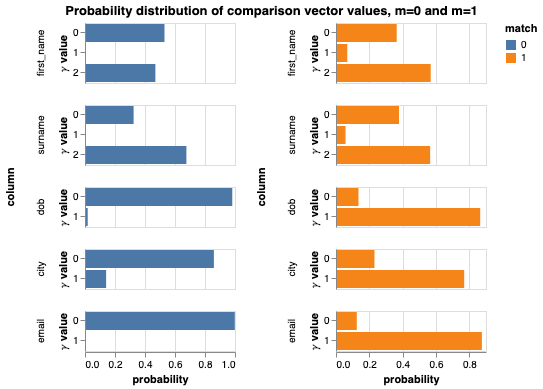

In [8]:
params = linker.params
params.probability_distribution_chart()

An alternative representation of the parameters displays them in terms of the effect different values in the comparison vectors have on the match probability:

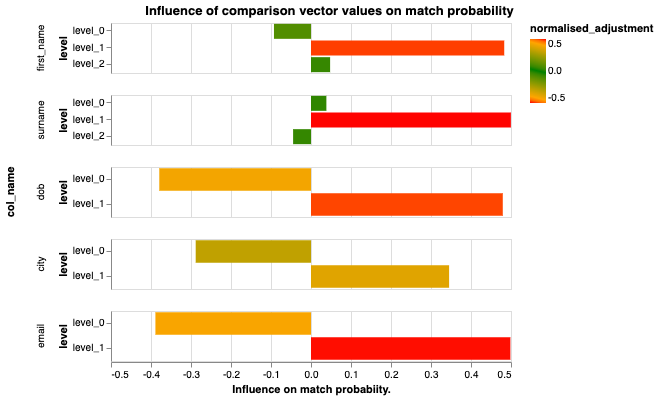

In [9]:
params.adjustment_factor_chart()

In [10]:
# If charts aren't displaying correctly in your notebook, you can write them to a file (by default splink_charts.html)
params.all_charts_write_html_file()

You can also generate a report which explains how the match probability was computed for an individual comparison row.  

Note that you need to convert the row to a dictionary for this to work

In [11]:
from splink.intuition import intuition_report
row_dict = df_e.toPandas().sample(1).to_dict(orient="records")[0]
print(intuition_report(row_dict, params))


Initial probability of match (prior) = λ = 0.4149475693702698

Comparison of first_name.  Values are:
first_name_l: Isablle 
first_name_r: Isabelle 
Comparison has 3 levels
𝛾 for this comparison = gamma_first_name = 2
Amongst matches, P(𝛾 = 0.5681893825531006):
Amongst non matches, P(𝛾 = 0.46906471252441406):
Adjustment factor = p1/(p1 + p2) = 0.5477822505107964
New probability of match (updated belief): 0.46211394468923145

Comparison of surname.  Values are:
surname_l: Brown
surname_r: Brown
Comparison has 3 levels
𝛾 for this comparison = gamma_surname = 2
Amongst matches, P(𝛾 = 0.5648982524871826):
Amongst non matches, P(𝛾 = 0.6759299039840698):
Adjustment factor = p1/(p1 + p2) = 0.4552590538352038
New probability of match (updated belief): 0.41792945584141206

Comparison of dob.  Values are:
dob_l: 1979-01-22
dob_r: 1979-01-22
Comparison has 2 levels
𝛾 for this comparison = gamma_dob = 1
Amongst matches, P(𝛾 = 0.8651984930038452):
Amongst non matches, P(𝛾 = 0.01816166192293167):
A

## Step 7: Term frequency adjustments

Splink enables you to make adjustments for term frequency on any number of columns

This enables match probabilities to be adjusted for e.g. the fact John Smith is more prevalent than Robin Linacre

In [12]:
df_e_adj = linker.make_term_frequency_adjustments(df_e)

In [13]:
pdtf = df_e_adj.toPandas()
sam = pdtf.sample(10)
sam[["match_probability", "tf_adjusted_match_prob"] + list(pdtf.columns)]

,match_probability,tf_adjusted_match_prob,tf_adjusted_match_prob,match_probability,unique_id_l,unique_id_r,first_name_l,first_name_r,gamma_first_name,prob_gamma_first_name_non_match,prob_gamma_first_name_match,first_name_adj,surname_l,surname_r,gamma_surname,prob_gamma_surname_non_match,prob_gamma_surname_match,surname_adj,dob_l,dob_r,gamma_dob,prob_gamma_dob_non_match,prob_gamma_dob_match,city_l,city_r,gamma_city,prob_gamma_city_non_match,prob_gamma_city_match,email_l,email_r,gamma_email,prob_gamma_email_non_match,prob_gamma_email_match,_source_table_l,_source_table_r,group_l,group_r
1767,0.004596,0.002267,0.002267,0.004596,303,526,Ivy,Ivy,2,0.469065,0.568189,0.329836,Cunninmha,Parker,0,0.324053,0.378006,0.500000,1990-11-02,1989-03-02,0,0.981838,0.134801,Norwich,London,0,0.859167,0.230821,alyssa01@torres.com,bellsara@davis-fisher.com,0,0.998651,0.124749,right,right,77,139
3640,0.001874,0.000505,0.000505,0.001874,14,141,Ollie,Freddie,0,0.529773,0.364264,0.500000,Thompson,Thompson,2,0.675930,0.564898,0.211883,1996-03-22,1999-07-23,0,0.981838,0.134801,Leeds,Peterborough,0,0.859167,0.230821,jefferyduke@brown-alazar.org,scottsalinas@hughes-lopez.com,0,0.998651,0.124749,right,right,5,36
1279,0.004596,0.005606,0.005606,0.004596,41,79,Isabella,Isabella,2,0.469065,0.568189,0.549720,Cooper,Wallace,0,0.324053,0.378006,0.500000,1987-11-18,2000-02-01,0,0.981838,0.134801,Stockton-on-Tees,Ldnon,0,0.859167,0.230821,imoore@turner-gonzalez.info,hilltheresa@pearson.org,0,0.998651,0.124749,right,right,15,23
5489,0.999993,0.999993,0.999993,0.999993,307,308,None,Carter,-1,1.000000,1.000000,0.500000,Carter,Alfie,0,0.324053,0.378006,0.500000,1997-03-13,1997-03-13,1,0.018162,0.865198,London,London,1,0.140833,0.769179,jennifermarshall@browning.com,jennifermarshall@browning.com,1,0.001349,0.875251,right,right,78,78
523,0.003943,0.001162,0.001162,0.003943,153,184,George,George,2,0.469065,0.568189,0.227142,None,Williams,-1,1.000000,1.000000,0.500000,1984-07-05,1981-08-06,0,0.981838,0.134801,London,Lndon,0,0.859167,0.230821,jonesjustin@myers.com,derek58@gibbs.biz,0,0.998651,0.124749,left,left,80,96
3419,0.999990,0.999951,0.999951,0.999990,297,585,None,Leo,-1,1.000000,1.000000,0.500000,Jones,Jones,2,0.675930,0.564898,0.169382,2019-06-15,2019-06-15,1,0.018162,0.865198,London,London,1,0.140833,0.769179,tcarr@lewis-kline.com,tcarr@lweis-kine.com,1,0.001349,0.875251,left,right,156,156
2213,0.994676,0.994289,0.994289,0.994676,599,601,Tyler,Tyler,2,0.469065,0.568189,0.563894,Hughes,Hughes,2,0.675930,0.564898,0.418874,1971-10-26,1971-10-26,1,0.018162,0.865198,Leeds,Leeds,1,0.140833,0.769179,None,dawn74@mckay.com,-1,1.000000,1.000000,right,right,164,164
4145,0.001874,0.000369,0.000369,0.001874,175,521,Owen,Patel,0,0.529773,0.364264,0.500000,Mohammed,Mohammed,2,0.675930,0.564898,0.164101,2018-01-17,1989-02-07,0,0.981838,0.134801,Cardiff,Sheffield,0,0.859167,0.230821,gkennedy@vincent.com,heather31@cabrera-reed.com,0,0.998651,0.124749,right,right,44,137
3401,0.010064,0.002069,0.002069,0.010064,296,575,Leo,None,-1,1.000000,1.000000,0.500000,Jones,Jones,2,0.675930,0.564898,0.169382,2019-06-15,1983-06-19,0,0.981838,0.134801,Ldnon,None,-1,1.000000,1.000000,tcarr@lewis-kline.com,smyers@andersen-lee.com,0,0.998651,0.124749,left,right,156,151
4518,0.014810,0.003085,0.003085,0.014810,343,499,Alfie,cMhael,0,0.529773,0.364264,0.500000,Taylor,Taylor,2,0.675930,0.564898,0.170693,2005-07-14,1993-06-23,0,0.981838,0.134801,London,Brighton,0,0.859167,0.230821,None,rhondawilliams@gonzalez-scott.com,-1,1.000000,1.000000,right,right,88,129
